In [9]:
from matplotlib import pyplot

1) В качестве предобученнной модели была взята Resnet101, датасет VOC

2) mAp для каждой точки изменялся не более чем на 0.0001, в связи с чем я для каждой точки стала запускать по 2 раза, брать среднее, для экономии вычислительных ресурсов.

3) В связи с предыдущим пунктом, я решила что изменение значений в 3 знаке показательно

4) - 5) 

Сначала я попыталась поменять параметр SCALES. Кажется, что он должен быть таким, чтобы не так много изображений сильно искажались (как здесь, так и в статье это 600). Я попробовала уменьшить и наоборот увеличить. Остановилась в изменении, так как улучшения в качестве не наблюдалось. Шаг был выбран небольшим для наблюдения динамики.

Самые очевидные параметры это размер (ANCHOR_SCALES) и пропорции (ANCHOR_RATIONS) у anchors (я не знаю как нормально на русский, что-то типа окон?)

ANCHOR_SCALES: Здесь изначально были размеры [8, 16, 32] (в основной статье было [128, 256, 512]), 
поэтому я попробовала их увеличить, но качество только ухудшалось, по всей видимости плохо распознавались более мелкие изображения, а если взять [4, 8, 16] - более крупные

Кажется, что при улучшении mAP можно было бы попытаться поизменять еще раз размер изображений, к которому все приводятся.

ANCHOR_RATIONS: была идея изменить пропорции окна, (помимо 1:1) взять не 0.5, а более естественную пропорцию 3:4 = 0,75

То есть я попыталась посмотреть на качество на anchors вида [a, 1, 2], где a < 1. После того, как mAP на [0.75, 1, 2] стала хуже я решила посмотреть на  промежуточном 0.6 и на формате 1:3 = 0.33. При отдалении от 0.5 mAP становилась хуже, поэтому я остановилась

Также я посмотрела на anchors вида [0.5, 1, b]. Была идея что может быть лучше на 1.25 или 1.33 или 2.5 для чего-то сильно вытянутого. mAP не увеличивалась.
Но наверное, такие штуки будут работать если смотреть не на 3, а 4 anchors.


POSITIVE TRESHOLD:
тут изначально был параметр как в статье, но было интересно, что будет если ослабить порог/ усилить порог пересечения с реальными объектами на изображении. Если сделать его сильно большим, то мало положительных примеров будут участвовать в обучении. Параметры варьировались от 0.6 до 0.8, так как меньшее пересечение уже будет мало включать изображение для классификации, больше 0.8 - мало anchors будет в обучении, да и mAP не улучшалась.

NEGATIVE TRESHOLD: чем больше у нас негативных примеров, тем меньше FP

STEPSIZE: Автор реализации приводит табличку с количеством итераций 350k и 600k, в коде же изначально было 300k
я решила увеличить и посмотреть насколько изменится результат, тут я проверила mAP 5 раз на максимальном значении.

Также, я пробовала изменять на трейне
RPN_PRE_NMS_TOP_N(топ N proposals после результаты работы RPN), RPN_POST_NMS_TOP_N (сколько мы оставляем proposals, если убрать пересекающиеся), но вообще никаких изменений не наблюдалось

In [2]:
start_config = {
    'RPN_CHANNELS': 512,
    'TEST': {
        'BBOX_REG': True,
        'HAS_RPN': True,
        'MAX_SIZE': 1000,
        'MODE': 'nms',
        'NMS': 0.3,
        'PROPOSAL_METHOD': 'gt',
        'RPN_NMS_THRESH': 0.7,
        'RPN_POST_NMS_TOP_N': 300,
        'RPN_PRE_NMS_TOP_N': 6000,
        'RPN_TOP_N': 5000,
        'SCALES': [600],
        'SVM': False
    },
    'TRAIN': {
        'ASPECT_GROUPING': False,
        'BATCH_SIZE': 256,
        'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
        'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
        'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
        'BBOX_NORMALIZE_TARGETS': True,
        'BBOX_NORMALIZE_TARGETS_PRECOMPUTED': True,
        'BBOX_REG': True,
        'BBOX_THRESH': 0.5,
        'BG_THRESH_HI': 0.5,
        'BG_THRESH_LO': 0.0,
        'BIAS_DECAY': False,
        'DISPLAY': 20,
        'DOUBLE_BIAS': False,
        'FG_FRACTION': 0.25,
        'FG_THRESH': 0.5,
        'GAMMA': 0.1,
        'HAS_RPN': True,
        'IMS_PER_BATCH': 1,
        'LEARNING_RATE': 0.001,
        'MAX_SIZE': 1000,
        'MOMENTUM': 0.9,
        'PROPOSAL_METHOD': 'gt',
        'RPN_BATCHSIZE': 256,
        'RPN_BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
        'RPN_CLOBBER_POSITIVES': False,
        'RPN_FG_FRACTION': 0.5,
        'RPN_NEGATIVE_OVERLAP': 0.3,
        'RPN_NMS_THRESH': 0.7,
        'RPN_POSITIVE_OVERLAP': 0.7,
        'RPN_POSITIVE_WEIGHT': -1.0,
        'RPN_POST_NMS_TOP_N': 500,
        'RPN_PRE_NMS_TOP_N': 6000,
        'SCALES': [600],
        'SNAPSHOT_ITERS': 5000,
        'SNAPSHOT_KEPT': 3,
        'SNAPSHOT_PREFIX': 'res101_faster_rcnn',
        'STEPSIZE': [30000],
        'SUMMARY_INTERVAL': 180,
        'TRUNCATED': False,
        'USE_ALL_GT': True,
        'USE_FLIPPED': True,
        'USE_GT': False,
        'WEIGHT_DECAY': 0.0001
    }
}

1) Обрезка изображения на патчи

In [18]:
AP_MEAN = [0.7126, 0.7649, 0.7978, 0.7898, 0.7926, 0.7912, 0.7945]
SCALES = [300, 400, 500, 600, 700, 800, 900]

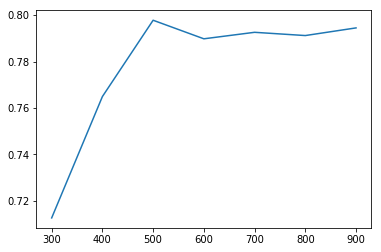

In [21]:
pyplot.plot(SCALES, AP_MEAN)

2) Варьирование границы отнесения "anchor" к какому-то объекту

In [22]:
AP_MEAN = [0.7965, 0.7975, 0.7978,  0.7935, 0.7932]
POSITIVE_TRESHOLD = [0.6, 0.65, 0.7, 0.75, 0.8]

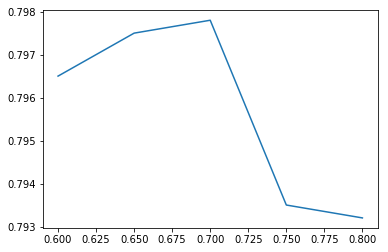

In [24]:
pyplot.plot(POSITIVE_TRESHOLD, AP_MEAN)

3) Варьирование границы отсутствия объекта

In [26]:
AP_MEAN = [0.7863, 0.7912, 0.7978, 0.8007, 0.7977]
NEGATIVE_TRESHOLD = [0.2, 0.25, 0.3, 0.35, 0.4]

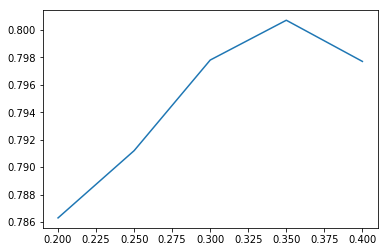

In [27]:
pyplot.plot(NEGATIVE_TRESHOLD, AP_MEAN)

Это уже при NEGATIVE_TRESHOLD = 0.35

In [33]:
AP_MEAN = [0.8009, 0.8007, 0.8034, 0.8010, 0.8007]
STEPSIZE = [20000, 30000, 40000, 45000, 50000]

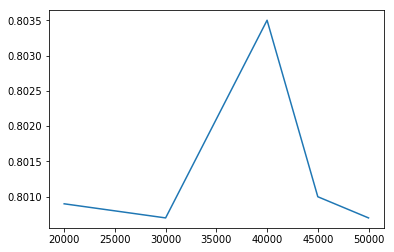

In [34]:
pyplot.plot(STEPSIZE, AP_MEAN)

5) Варьирование размеров "anchor" [4, 8, 16] -> [8, 16, 32] -> [16, 32, 64] -> [64, 32, 128] 

In [35]:
AP_MEAN = [0.5923, 0.8034, 0.7457, 0.6417, 0.5552]
ANCHOR_SCALE = [4, 8, 16, 32, 64]

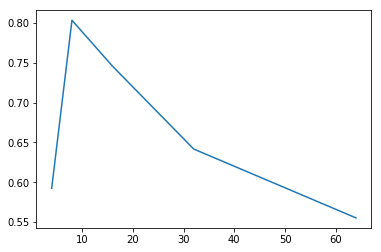

In [36]:
pyplot.plot(ANCHOR_SCALE, AP_MEAN)

6) Изменение пропорций 

 [a, 1, 2] 

In [41]:
AP_MEAN = [0.8011, 0.8030, 0.8034, 0.8026, 0.8019]
ANCHOR_RATIONS = [0.3, 0.4, 0.5, 0.6, 0.75]

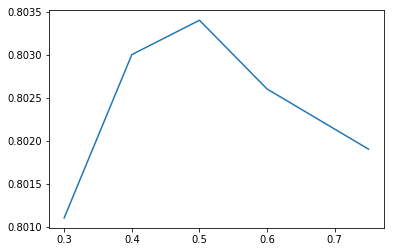

In [42]:
pyplot.plot(ANCHOR_RATIONS, AP_MEAN)

 [0.5, 1, b] 

In [46]:
AP_MEAN = [0.8011, 0.8034, 0.8020, 0.8017, 0.8013]
ANCHOR_RATIONS = [1.25, 2, 2.25, 2.5, 3]

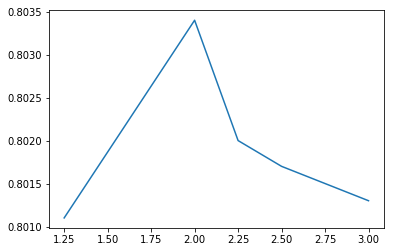

In [47]:
pyplot.plot(ANCHOR_RATIONS, AP_MEAN)